In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import svm
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network
from sklearn import tree
from sklearn import ensemble

from scipy import signal
import warnings
import xgboost as xgb
import catboost as cb
import optuna

# IO utils


# Data

In [2]:
palm_files = [
    './temp/2024-03-04_08-17-49.emg8',
    './temp/2024-03-04_10-00-21.emg8',
    './temp/2024-03-04_11-11-02.emg8'
]
palm_file = palm_files[1] # change index [0, 1, 2]
gestures = pd.read_csv(palm_file, sep=' ', on_bad_lines='skip')
gestures = gestures[~gestures['state'].isin(['Baseline', 'Finish'])]
gestures.sort_index(inplace=True)
gestures.reset_index(drop=True, inplace=True)

print(gestures.shape)
gestures.head()

(6364, 56)


,ts,td,0,1,2,3,4,5,6,7,...,44,45,46,47,48,49,prot,state,id,now
0,1366859.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.00
1,1366892.0,33.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.04
2,1366925.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.07
3,1366958.0,33.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.10
4,1366991.0,33.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.13


In [3]:
OMG_CH = np.arange(50).astype(str)

In [4]:
# [X features] '0', ..., '49' - каналы OMG датчиков
# 'ts' - метка времени
gestures.columns

Index(['ts', 'td', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', 'prot', 'state', 'id', 'now'],
      dtype='object')

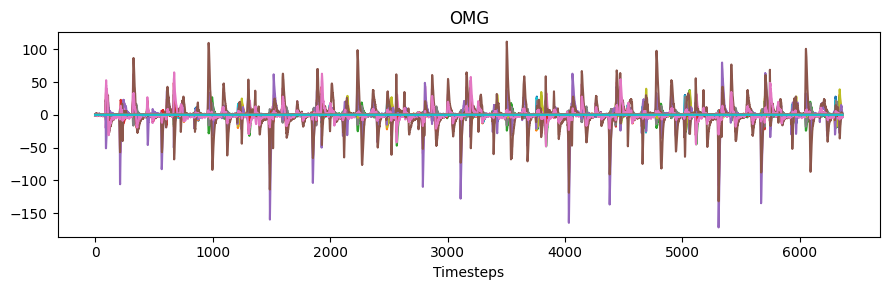

In [5]:
fig = plt.figure(figsize=(9, 3))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

In [6]:
X = gestures[OMG_CH].values

le = preprocessing.LabelEncoder()
state = gestures['state'].values
y_cmd = le.fit_transform(state)

display(np.c_[le.transform(le.classes_), le.classes_])

print(X.shape, y_cmd.shape)

array([[0, 'Close'],
       [1, 'Indication'],
       [2, 'Neutral'],
       [3, 'Open'],
       [4, 'Pinch'],
       [5, 'ThumbFingers']], dtype=object)

(6364, 50) (6364,)


In [7]:
GESTURES = le.classes_
GESTURES

array(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'],
      dtype=object)

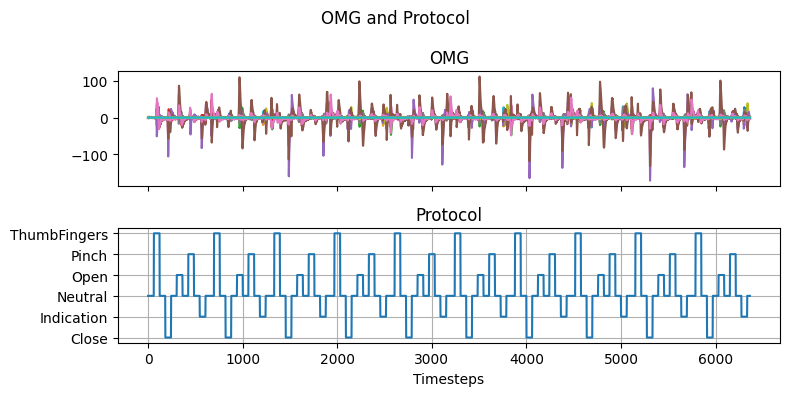

In [8]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

---
---
---

# Preprocessing

In [9]:
# Функция для отрисовки графики "OMG and Protocol" для заданного интервала
def get_graphs(X_array, y_array, start=1000, end=1500):
    
    _, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.grid(axis='y')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

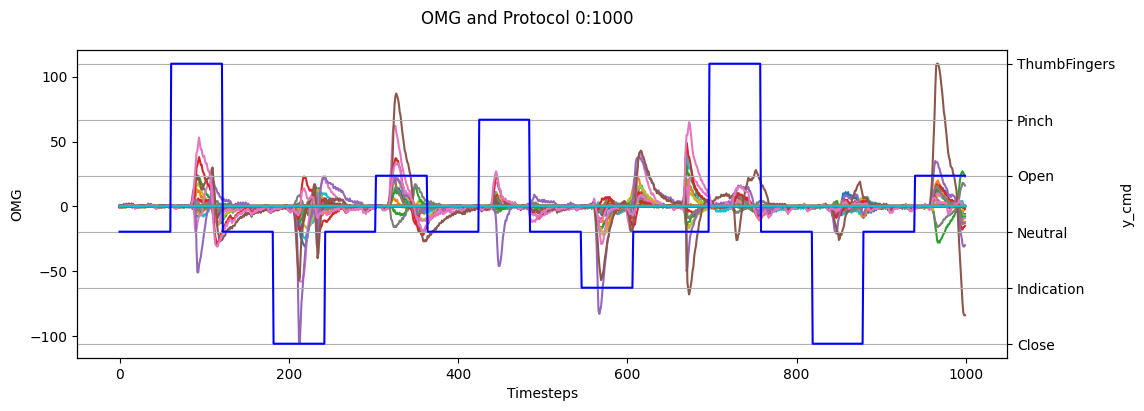

In [10]:
get_graphs(gestures[OMG_CH].values, y_cmd, start=0, end=1000)

Данные с датчиков будто немного отстают от команд. Оператор, что естественно, делает жест с некоторым лагом. Чтобы обучить модель определять тип жеста по данным, нм необходимо немного сдвинуть таргет: это может повысить качество обучающих данных.

## Устранение лага между сигналами датчиков и таргетом

In [11]:
def get_naive_centering(X_arr, y_arr, gap=500, inter=1000, window=20, use_m=True, model=svm.SVC()):
    """Функция для устранения глобального лага между сигналами датчиков и таргетом.

    Args:
        X_arr (ndarray): Массив данных.
        y_arr (ndarray): Вектор целевого признака.
        gap (int, optional): Размеры концевых отступов. Defaults to 500.
        inter (int, optional): Величина концевых выборок. Defaults to 1000.
        window (int, optional): Величина окна поиска оптимального сдвига. Defaults to 20.
        use_m (bool, optional): Использование модели для поиска оптимального сдвига.
            Defaults to True. False: поиск сдвига по корреляции таргета с вектором
            суммы модулей дифференциалов векторов признаков массива данных.
        model (_type_, optional): Алгоритм scikit-learn. Defaults to svm.SVC().

    Returns:
        tuple():
            ndarray: Вектор сдвинутого таргета.
            list: Строки отчета по проделанным операциям.
    """
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    # Функция для сдвига таргета
    def shifter(y_arr, shift=1):
        first_element = y_arr[0]
        prefix = np.full(shift, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-shift]
    
        return y_arr_shifted
    
    # Функция для расчета точности модели
    def get_score(X, y, model=model):
        model = model
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    # Функция для расчета корреляции
    def get_corr(X, y):
        x_diff = pd.DataFrame(X).diff().abs().sum(axis=1)
        correlation = np.corrcoef(x_diff, y)[0, 1]
        
        return abs(correlation)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    s1, s2 = 1, 1
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, shift=i)
        y_b = shifter(y_part2, shift=i)
        
        if use_m:
            current_score1 = get_score(X_part1, y_a)
            current_score2 = get_score(X_part2, y_b)
        else:
            current_score1 = get_corr(X_part1, y_a)
            current_score2 = get_corr(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            s1 = i
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            s2 = i
    
    optimal_shift = round((s1+s2)/2)
    y_arr_shifted = shifter(y_arr, shift=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок:   {s1} и {s2}\n',
        f'Accuracy/correlation на концевых выборках: {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига (как среднего): {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

In [12]:
X = gestures[OMG_CH].values
fitting_model = svm.LinearSVC(dual='auto')
y_shifted, summary = get_naive_centering(X, y_cmd, gap=20, inter=100, use_m=False, model=fitting_model)

print('Test sample shifting\n', *summary, sep='')

Test sample shifting
Оптимальные свдиги для концевых выборок:   20 и 20
Accuracy/correlation на концевых выборках: 0.7544102067448368; 0.5373318229830528
Размер оптимального сдвига (как среднего): 20


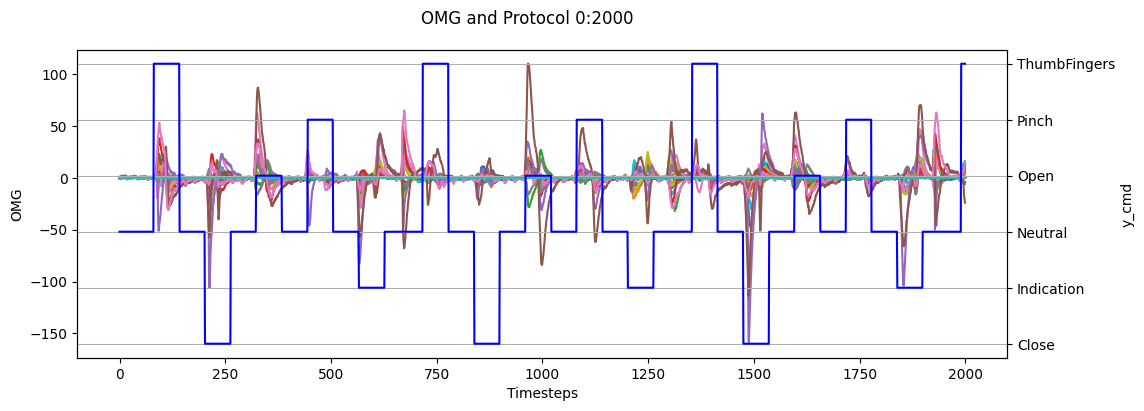

In [13]:
get_graphs(X, y_shifted, start=0, end=2000)

---

In [14]:
# X_log = np.log(np.abs(X))

# get_graphs(X_log, y_shifted, start=0, end=2000)

---

In [15]:
# from sklearn.linear_model import LinearRegression
# # Функция для формирования признакового описания с использованием линейной регрессии
# def feature_description(X, num_segments):
#     segment_length = X.shape[0] // num_segments
    
#     all_w_g = []  # Список для хранения параметров модели для каждого сегмента
    
#     for i in range(num_segments):
#         start_idx = i * segment_length
#         end_idx = (i + 1) * segment_length
        
#         # Разделение данных на признаки и целевую переменную для текущего сегмента
#         X_segment = X[start_idx:end_idx, :-1]
#         y_segment = X[start_idx:end_idx, -1]
        
#         # Обучение модели линейной регрессии для текущего сегмента
#         model = LinearRegression()
#         model.fit(X_segment, y_segment)
        
#         # Получение оптимальных параметров модели для текущего сегмента
#         w_g = model.coef_
#         all_w_g.append(w_g)
    
#     return all_w_g

# # Вызов функции для формирования признакового описания с разбиением на 2 сегмента
# num_segments = 2
# all_w_g = feature_description(X, num_segments)

# print("Оптимальные параметры модели для каждого сегмента:")
# for i, w_g in enumerate(all_w_g):
#     print(f"Сегмент {i+1}: {w_g}")

## Сплитование

In [16]:
X_train = X[:int(X.shape[0] * 0.8)+1]
X_valid = X[int(X.shape[0] * 0.8)+1:]

y_train = y_shifted[:int(X.shape[0] * 0.8)+1]
y_valid = y_shifted[int(X.shape[0] * 0.8)+1:]

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(5092, 50) (5092,)
(1272, 50) (1272,)


## Корреляционный анализ

In [17]:
def find_highly_correlated_features(data, threshold=0.9):
    """Функция корреляционного анализа

    Args:
        data (ndarray): Массив данных.
        threshold (float, optional): Порог корреляции. Defaults to 0.9.

    Returns:
        tuple:
            list: Спсиок пар номеров высоко скореллированных признаков.
            set: Множество оптимально-отобранных номеров признаков из
                высоко скореллированных пар.
    """
    # Строим корреляционную матрицу
    corr_matrix = np.corrcoef(data, rowvar=False)
    
    # Находим индексы нижнего треугольника корреляционной матрицы
    lower_triangle_indices = np.tril_indices(corr_matrix.shape[0], k=-1)
    
    # Находим пары высоко скоррелированных признаков
    high_corr_features = [
        [j, i] for i, j in zip(
            lower_triangle_indices[0], lower_triangle_indices[1]
        ) if abs(corr_matrix[i, j]) > threshold
    ]

    hcf_copy = high_corr_features.copy()
    # Определяем features_to_remove
    features_to_remove = []
    while True:
        dct = {}
        for el in hcf_copy:
            for num in el:
                cnt = 0
                for l in hcf_copy:
                    if (num in l) and (len(l) == 2):
                        cnt += 1
                dct[num] = cnt
        
        if (len(set(dct.values())) == 1) and list(dct.values())[0] == 0:
            break
        
        if not dct:
            break

        num_tb_dltd = max(dct, key=dct.get)
        features_to_remove.append(num_tb_dltd)

        hcf_copy = [
            [x for x in inner_list if x != num_tb_dltd]
            for inner_list in hcf_copy
        ]

    return high_corr_features, list(set(features_to_remove))

In [18]:
high_corr_features, features_to_remove = find_highly_correlated_features(X_train, threshold=0.9)
print(high_corr_features)
print(features_to_remove)
print(f'Всего отобрано уникальных признаков на удаление: {len(features_to_remove)}')

[]
[]
Всего отобрано уникальных признаков на удаление: 0


c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Однако простое удаление этого ряда признаков нечасто приводит к улучшению качества прогнозирования. Это может быть следствием того, что среди удаляемых признаков могут случайно оказаться те, что хорошо скоррелированы с целевым признаком. Этот момент необходимо исследовать отдельно.

In [19]:
def find_weakly_correlated_features(features, target, threshold):
    # Вычисляем коэффициент корреляции для каждого признака
    corr_values = np.abs(np.corrcoef(features, target, rowvar=False)[:-1, -1])  
    # Находим индексы признаков с корреляцией ниже порога
    weakly_correlated_features = np.where(corr_values < threshold)[0]  

    return weakly_correlated_features

In [20]:
# Порог корреляции
threshold = 0.2

# Поиск плохо скоррелированных признаков
weakly_corr_fs = find_weakly_correlated_features(X_train, y_train, threshold)
print(list(weakly_corr_fs))

[0, 1, 8, 9, 10, 11, 12, 17, 18, 20, 22, 23, 26, 27, 30, 33, 34, 35, 36, 40]


Теперь остается найти пересечения между рядами высоко скоррелированных между собой признаков и списком тех, что плохо скоррелированны с целевой переменной.

In [21]:
bad_features = list(set(weakly_corr_fs) & set(features_to_remove))
print(bad_features)

[]


Но даже столь организованный подбор признаков для удаления может не дасть хороших результатов, и даже ухудшить их.

In [22]:
# X_train_cd = np.delete(X_train, bad_features, axis=1)
# X_valid_cd = np.delete(X_valid, bad_features, axis=1)

## Стандартизация

In [23]:
std_scaler = preprocessing.StandardScaler()

# X_train_scaled = std_scaler.fit_transform(X_train_cd)
# X_valid_scaled = std_scaler.transform(X_valid_cd)

X_train_scaled = std_scaler.fit_transform(X_train)
X_valid_scaled = std_scaler.transform(X_valid)

## Понижение размерности

In [24]:
# Включаем предупреждениe как исключениe
warnings.simplefilter('error', RuntimeWarning)

# Матрица корреляций
corr_mtrx = pd.DataFrame(data=X_train_scaled).corr()

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])

# Расчет ранга матрицы либо перехват исключения
try:
    matrix_rank = np.linalg.matrix_rank(corr_mtrx)
except Exception as e:
    print('Ошибка:', e)
else:
    print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
    
# Расчет определителя либо перехват предупреждения
try:
    det = np.linalg.det(corr_mtrx)
except RuntimeWarning as rw:
    print(f"""Ошибка вычисления определителя: {rw}
Матрица корреляций является вырожденной""")
else:
    print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 50
Ошибка: SVD did not converge
Ошибка вычисления определителя: invalid value encountered in det
Матрица корреляций является вырожденной


In [25]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99,99 % разброса данных
pca = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_train_scaled)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

Число компонент: 20


In [26]:
X_train_pca = pca.transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
# Матрица корреляций
corr_mtrx = np.corrcoef(X_train_pca.transpose())

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 20
Ранг матрицы:   20
Определитель:   0.9999999999999997


## Экспоненциальное сглаживаение

In [27]:
def get_convolve(data, M=10, tau=3, sym=True):
    win = signal.windows.exponential(M, tau=tau, sym=sym)
    data_result = np.zeros((data.shape[0]))
    for i in range(data.shape[1]):
        sig = data[:, i]
        filtered = signal.convolve(sig, win, mode='same') / sum(win)
        data_result = np.column_stack((data_result, filtered))
        
    return data_result[:, 1:]

In [28]:
X_train_ce = get_convolve(X_train_pca, M=10, tau=1, sym=False)
X_valid_ce = get_convolve(X_valid_pca, M=10, tau=1, sym=False)

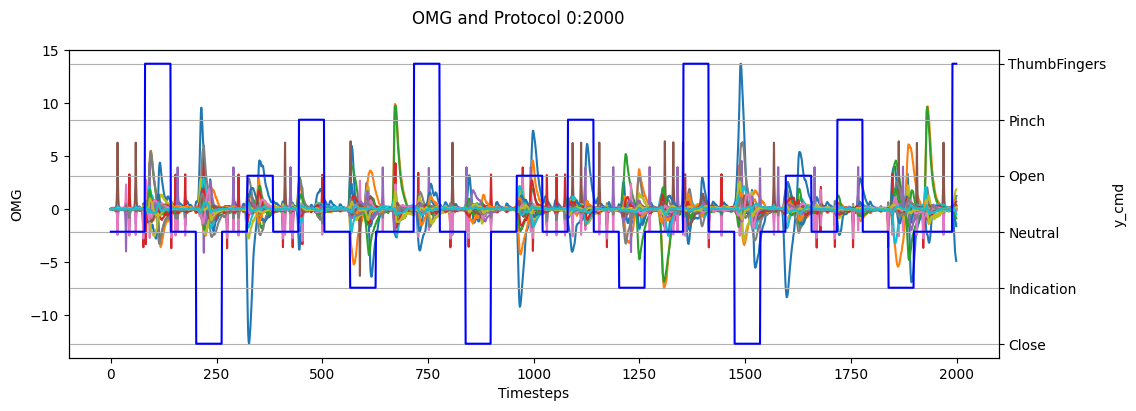

In [29]:
get_graphs(X_train_ce, y_train, start=0, end=2000)

---
---
---

# Modeling

---
### LogisticRegression

In [30]:
# model = linear_model.LogisticRegression(solver='liblinear')

# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

---
### SVC

In [31]:
# %%time
# # Инициализация объекта
# model = svm.SVC(
#     kernel='rbf',
#     random_state=42
# )

# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

---
### KNeighborsClassifier

In [32]:
# model = neighbors.KNeighborsClassifier()

# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

---
### MLPClassifier

In [33]:
# model = neural_network.MLPClassifier(
#     max_iter=1000
# )

# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

---
### DecisionTreeClassifier

In [34]:
# model = tree.DecisionTreeClassifier()

# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

---
### AdaBoostClassifier

In [35]:
# # Инициализация объекта
# model = ensemble.AdaBoostClassifier(
#     estimator=tree.DecisionTreeClassifier(),
#     random_state=42
# )

# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

---
### BaggingClassifier

In [36]:
# model = ensemble.BaggingClassifier(
#     random_state=42
# )

# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

---
### ExtraTreesClassifier

In [37]:
# model = ensemble.ExtraTreesClassifier(
#     random_state=42
# )

# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

---
### GradientBoostingClassifier

In [38]:
# model = ensemble.GradientBoostingClassifier(
#     random_state=42
# )

# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

0.9752553024351924

---
### RandomForestClassifier

In [39]:
# # Инициализация объекта
# model = ensemble.RandomForestClassifier(
#     random_state=42
# )

# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

---
### HistGradientBoostingClassifier

In [40]:
# # Инициализация объекта
# model = ensemble.HistGradientBoostingClassifier(
#     random_state=42
# )

# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

---
### XGBClassifier

In [63]:
# Инициализация объекта
model = xgb.XGBClassifier()

# Обучение
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

1.0

---
### CatBoostClassifier

In [42]:
# # Инициализация объекта
# model = cb.CatBoostClassifier(verbose=False)

# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

## Prediction

In [64]:
preds_train = model.predict(X_train_ce)
preds_valid = model.predict(X_valid_ce)

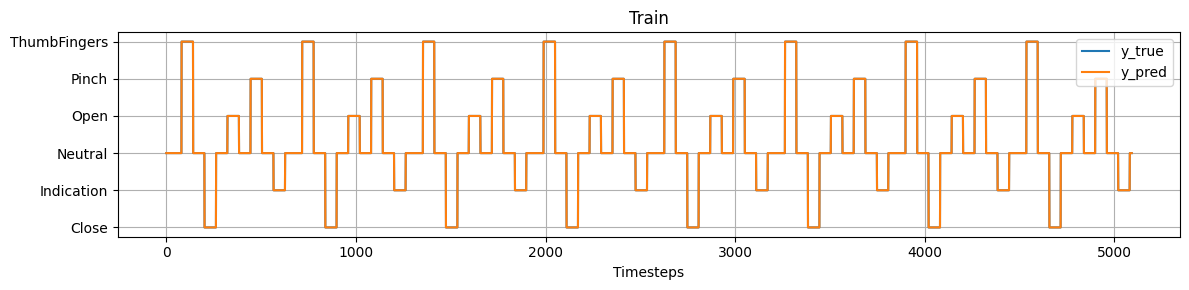

In [65]:
fig = plt.figure(figsize=(12, 3))
plt.plot(y_train, label='y_true')
plt.plot(preds_train, label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

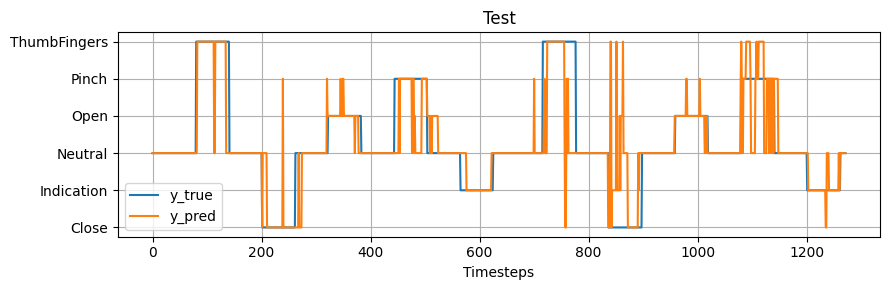

In [66]:
fig = plt.figure(figsize=(9, 3))
plt.plot(y_valid, label='y_true')
plt.plot(preds_valid, label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [67]:
print('Train preds metrics report:')
print(metrics.classification_report(
    y_train, preds_train, target_names=GESTURES, digits=4, zero_division=0))
print('-'*55)
print('Test preds metrics report:')
print(metrics.classification_report(
    y_valid, preds_valid, target_names=GESTURES, digits=4, zero_division=0))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_valid, preds_valid.reshape(-1))
if not list(ct.index) == list(ct.columns):
    set1, set2 = set(ct.index), set(ct.columns)
    diff = set1.difference(set2)
    if len(diff) == 1:
        specific_index = list(ct.index).index(list(diff)[0])
        new_column_name = str(diff)
        ct.insert(specific_index, new_column_name, 0)
        # определяем название активностей
        ct.index = ct.columns = GESTURES
        display(ct)
    else:
        print('Более чем один жест моделью не распознается!')
else:
    ct.index = ct.columns = GESTURES
    display(ct)

Train preds metrics report:
              precision    recall  f1-score   support

       Close     1.0000    1.0000    1.0000       485
  Indication     1.0000    1.0000    1.0000       486
     Neutral     1.0000    1.0000    1.0000      2667
        Open     1.0000    1.0000    1.0000       486
       Pinch     1.0000    1.0000    1.0000       484
ThumbFingers     1.0000    1.0000    1.0000       484

    accuracy                         1.0000      5092
   macro avg     1.0000    1.0000    1.0000      5092
weighted avg     1.0000    1.0000    1.0000      5092

-------------------------------------------------------
Test preds metrics report:
              precision    recall  f1-score   support

       Close     0.8222    0.6066    0.6981       122
  Indication     0.8584    0.8017    0.8291       121
     Neutral     0.8276    0.9383    0.8795       665
        Open     0.8015    0.8678    0.8333       121
       Pinch     0.7403    0.4711    0.5758       121
ThumbFingers     0.77

,Close,Indication,Neutral,Open,Pinch,ThumbFingers
Close,74,16,22,5,1,4
Indication,2,97,22,0,0,0
Neutral,12,0,624,19,10,0
Open,0,0,10,105,6,0
Pinch,0,0,43,1,57,20
ThumbFingers,2,0,33,1,3,83


F1-weighted scores
|model|set1|set2|set3|
|-|-|-|-|
|`LogisticRegression`|0.5289|0.4775|0.8809|
|`SVC`|0.8560|0.7791|0.8681|
|`KNeighborsClassifier`|0.9170|0.8098|0.8565|
|`MLPClassifier`|0.9052|0.8117|0.8893|
|`DecisionTreeClassifier`|0.8456|0.7106|0.8455|
|`AdaBoostClassifier`|0.8522|0.7037|0.8426|
|`BaggingClassifier`|0.8846|0.7820|0.8628|
|`ExtraTreesClassifier`|0.8809|0.8251|0.8954|
|`GradientBoostingClassifier`|0.9202|0.7771|0.8900|
|`RandomForest`|0.9046|0.8234|0.8897|
|`HistGradientBoostingClassifier`|0.9128|0.8300|0.8901|
|`XGBClassifier`|0.8985|0.8092|0.9057|
|`CatBoostClassifier`|0.9162|0.8339|0.9015|

# Real-time inference

In [47]:
import time
import serial
from IPython.display import clear_output

## Inference Utils: Put your code here

In [68]:
def preprocessing(x, prev, sample_size=10):
    # x - sample vector
    if prev is None:
        # x = np.delete(x.reshape(1, -1), bad_features, axis=1)
        # prev = np.log(np.abs(x.reshape(1, -1))+1)
        prev = x.reshape(1, -1)
        prev_scaled = std_scaler.transform(prev)
        prev_pca = pca.transform(prev_scaled)
        y = prev_pca
    else:
        # x = np.delete(x.reshape(1, -1), bad_features, axis=1)
        # prev = np.vstack((prev, np.log(np.abs(x.reshape(1, -1))+1)))
        prev = np.vstack((prev, x.reshape(1, -1)))
        if prev.shape[0] < sample_size:
            prev_scaled = std_scaler.transform(prev)
            prev_pca = pca.transform(prev_scaled)
            y = get_convolve(prev_pca, M=10, tau=3, sym=True)[-1]
        else:
            prev = prev[1:]
            prev_scaled = std_scaler.transform(prev)
            prev_pca = pca.transform(prev_scaled)
            y = get_convolve(prev_pca, M=10, tau=3, sym=True)[-1]
            
    return y.reshape(1, -1), prev


def inference(x):
    # y = model.predict_proba([x])[0]
    y = model.predict(x)
    
    return y


def postprocessing(x, prev, length=5):
    # if prev is None:
    #     y = x
    # else:
    #     y = x*0.1 + prev*0.9 # Holt-Winters filter

    if prev is None:
        prev = np.zeros((length,))
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    else:
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
        
    return y, prev


def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    
    return y


# def commands(x):
#     cmd = vp.neutral_state.copy()
#     # for this mapping look at GESTURES
#     if x == 0: # 'Close'
#         cmd.update({'thumb_flex': 1, 'index_flex': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
#         return cmd
#     elif x == 1: # 'Indication'
#         cmd.update({'thumb_extend':1, 'index_extend': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
#         return cmd
#     elif x == 2: # 'Neutral'
#         pass
#         return cmd
#     elif x == 3: # 'Open'
#         cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
#         return cmd
#     elif x == 4: # 'Pinch'
#         cmd.update({'thumb_flex':1, 'index_flex': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
#         return cmd
#     elif x == 5: # 'ThumbFingers'
#         cmd.update({'thumb_flex': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
#         return cmd
#     else:
#         return cmd

## Inference

### Offline (dataset)

In [77]:
df_sim = gestures.iloc[:, :52][int(X.shape[0] * 0.8)+1:]
target = y_shifted[int(X.shape[0] * 0.8)+1:]
print(df_sim.shape, target.shape)

(1272, 52) (1272,)


In [50]:
# Отключаем предупреждения DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

Текст предупреждения:<br>*DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)*

Строка кода, вызывающее предупреждение:<br>`prev[0] = x`

In [51]:
sample = df_sim.values[0]
[[ts, cycle_ts], omg_sample] = np.array_split(sample, [2])
sample_preprocessed, x_previous = preprocessing(omg_sample, None)
y_predicted = inference(sample_preprocessed)
y_postprocessed, y_previous = postprocessing(y_predicted, None, length=5)
y_previous

array([2, 0, 0, 0, 0])

In [80]:
LENGTH = 3
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

ts_diffs = []
x_previous = None
y_previous = None
y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [[ts, cycle_ts], omg_sample] = np.array_split(sample, [2])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed, x_previous = preprocessing(omg_sample, x_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed, y_previous = postprocessing(y_predicted, y_previous, length=LENGTH)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands = commands(y_postprocessed.argmax())
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    # y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=52, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        # print('INPUT:\n', s)
        print('SAMPLE:\n', sample)

        # sanity check: Sizes of SAMPLE=65, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
        print(y_postprocessed)
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    ts_diffs.append(ts_diff)
    i += 1 

In [81]:
np.max(ts_diffs)

0.002002716064453125

In [82]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (1272, 50)
sample_preprocessed.shape = (1272, 1, 20)
y_predicted.shape = (1272, 1)
y_postprocessed.shape = (1272,)
y_commands.shape = (1272,)


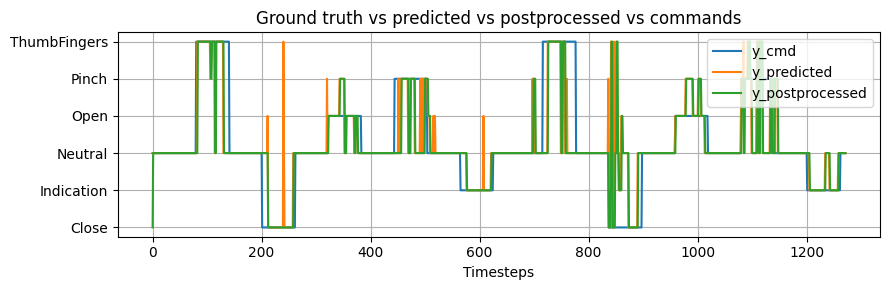

In [83]:
fig = plt.figure(figsize=(9, 3))

plt.plot(target, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'].reshape(-1), c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [84]:
print(metrics.classification_report(
    target, y_dct['y_postprocessed'],
    target_names=GESTURES, digits=4,
    zero_division=0
))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_valid, preds_valid.reshape(-1))
if not list(ct.index) == list(ct.columns):
    set1, set2 = set(ct.index), set(ct.columns)
    diff = set1.difference(set2)
    if len(diff) == 1:
        specific_index = list(ct.index).index(list(diff)[0])
        new_column_name = str(diff)
        ct.insert(specific_index, new_column_name, 0)
        # определяем название активностей
        ct.index = ct.columns = GESTURES
        display(ct)
    else:
        print('Более чем один жест моделью не распознается!')
else:
    ct.index = ct.columns = GESTURES
    display(ct)

              precision    recall  f1-score   support

       Close     0.9863    0.5902    0.7385       122
  Indication     0.9278    0.7438    0.8257       121
     Neutral     0.7633    0.9744    0.8560       665
        Open     0.9268    0.6281    0.7488       121
       Pinch     0.5000    0.3388    0.4039       121
ThumbFingers     0.8202    0.5984    0.6919       122

    accuracy                         0.7862      1272
   macro avg     0.8207    0.6456    0.7108      1272
weighted avg     0.7963    0.7862    0.7729      1272



,Close,Indication,Neutral,Open,Pinch,ThumbFingers
Close,74,16,22,5,1,4
Indication,2,97,22,0,0,0
Neutral,12,0,624,19,10,0
Open,0,0,10,105,6,0
Pinch,0,0,43,1,57,20
ThumbFingers,2,0,33,1,3,83


F1-weighted scores
|model|set1|set2|set3|
|-|-|-|-|
|`LogisticRegression`|0.4578|0.4471|0.8912|
|`SVC`|0.8263|0.7107|0.8684|
|`KNeighborsClassifier`|0.9183|0.7736|0.7027|
|`MLPClassifier`|0.9000|0.8062|0.9215|
|`DecisionTreeClassifier`|0.8600|0.6834|0.8563|
|`AdaBoostClassifier`|0.8546|0.6817|0.8676|
|`BaggingClassifier`|0.8984|0.7620|0.9032|
|`ExtraTreesClassifier`|0.8849|0.7580|0.9035|
|`GradientBoostingClassifier`|0.9268|0.7409|0.9032|
|`RandomForestClassifier`|0.9160|0.7816|0.9112|
|`HistGradientBoostingClassifier`|0.9196|0.7763|0.9074|
|`XGBClassifier`|0.9225|0.7796|0.9114|
|`CatBoostClassifier`|0.9309|0.8196|0.9072|

### Online (prosthesis or virtual hand)

In [57]:
# from copy import deepcopy
# import MotoricaInterface as mi; assert(mi.__version__=="0.0.3") # last time tested
# vp = mi.VirtualPhantomClient('localhost', 1755)

In [58]:
# !ls /dev/ttyUSB*

In [59]:
# TIMEOUT = 0.033
# DEBUG = True

# ser = None
# ser_port = None
# ser_port = '/dev/ttyUSB1'

# if ser_port is not None:
#     ser = serial.Serial(port=ser_port, baudrate=115200, timeout=1.0)
#     # time.sleep(0.2)

#     # ser.write('M0\r\n'.encode())
#     # time.sleep(0.1)

#     # # ser.write('S2\r\n'.encode())
#     # # time.sleep(0.1)

#     # ser.write('PT\r\n'.encode())
#     # time.sleep(0.1)
#     # ser.write('Pt\r\n'.encode())
#     # time.sleep(0.1)
#     # ser.flush()

#     # time.sleep(0.1)

In [60]:
# def parseline():
#     line = ser.readline().decode().replace('\n', '')
#     data = np.array(list(filter(len, np.array(line.split(" "))))).astype(float)
#     return data

# ser.readline()
# while True:
#     data = parseline()
#     print(f"data len: {len(data)} |", list(data), end = '                                          \r')

In [61]:
# # flush buffers
# ser.reset_input_buffer()
# ser.read()

# i = 0;
# while(ser.in_waiting):
#     print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
#     ser.read_all()
#     time.sleep(0.005)
#     i+=1;
# ser.readline()
# ser.readline()
    
# i = 0
# ts_old = time.time()
# ts_diff = 0;

# ts_diffs = []
# x_previous = None
# y_previous = None

# pack = None

# prev_state = 'None'
# prev_idx = -1
# y_commands = vp.neutral_state.copy()

# while True:    
    
#     # [Data reading]
#     s = ser.readline()
#     ts_start = time.time()
    
#     try:
#         sample = s.decode().replace('\n', '')
#         data = np.array(list(filter(len, np.array(sample.split(" "))))).astype(float)
#         [[ts, cycle_ts], omg_sample] = np.array_split(data, [2])
        
#     except Exception as e:
#         print(e)
#     # [/Data Reading]
        
#     # [Data preprocessing]
#     sample_preprocessed = preprocessing(omg_sample)
#     # [/Data preprocessing]
    
#     # [Inference]
#     y_predicted         = inference(sample_preprocessed)
#     # [/Inference]
    
#     # [Inference Postprocessing]
#     y_postprocessed     = postprocessing(y_predicted, y_previous)
#     # [/Inference Postprocessing]
    
#     # [Commands composition]
#     y_commands          = commands(y_postprocessed.argmax())
#     # [/Commands composition]
    
#     # [Commands sending]
#     # pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
#     prot_idx = deepcopy(y_commands)
#     if (prot_idx!=prev_idx):
#         # socket_send(row.Command)
#         vp.send_cmd(**y_commands)
#         prev_idx = prot_idx
#     # [/Commands sending]
    
#     y_previous = y_postprocessed

    
#     if DEBUG:
#         clear_output(wait=True)

#         # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
#         print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
#         # print('INPUT:\n', s)
#         print('SAMPLE:\n', sample)

#         # sanity check: Sizes of SAMPLE=65, OMG=50
#         print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
#         print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
#         print(y_postprocessed, GESTURES[y_postprocessed])
#         # print(y_commands)
#         # print(pack)
    
#     ts_diff = time.time() - ts_start
#     # assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
#     ts_old = ts_start
#     i += 1 

# Draft

In [62]:
# crc_table = [
#     54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
#     111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
#     113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
#     179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
#     115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
#     88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
#     97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
#     45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
#     153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
#     114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
#     215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
#     0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
#     18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
#     57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
#     193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
#     213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
#     137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
#     67, 112, 109, 78, 114, 165, 244, 183, 121
# ];
    
# def get_crc(data, count):
#     result = 0x00
#     l = count
#     while (count>0):   
#         result = crc_table[result ^ data[l-count]]
#         count -= 1;
#     return result;

# def drv_abs_one(ser, control):
#     if ser is None:
#         return
#     pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
#     pack[-1] = get_crc(pack[1:], 9)
#     return (pack, ser.write(bytearray(pack)))

---